In [1]:
from utils_v1 import *
experiment_path = 'D:/jorg/phd/fifth_semester/project_forestcare/dataset_deforestation/experiments/'
label_path = 'D:/jorg/phd/fifth_semester/project_forestcare/cloud_removal/dataset/Para_10m/'
optical_im_path = 'D:/jorg/phd/fifth_semester/project_forestcare/dataset_deforestation/Para_2020/'

In [2]:
# Loading reference
label_mask = np.load(label_path + 'mask_label_17730x9203.npy').astype('float32')
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

Mask label shape:  
 (17730, 9203) 
 Unique values:  
 [0. 1. 2.]


In [3]:
# Creating tile mask
grid_x, grid_y = 5,4
mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], grid_size=(grid_x, grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [4]:
# Loading image stack
image_stack = np.load(optical_im_path + 'optical_im.npy').astype('float32')
print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

Image shape:  (17730, 9203, 13)
mask:  (17730, 9200)
image stack:  (17730, 9200, 13)
ref : (17730, 9200)


In [5]:
# Defining tiles for training, validation and test sets
tiles_tr = [1,3,5,8,11,13,14,20] 
tiles_val = [6,19]
tiles_ts = list(set(np.arange(grid_x * grid_y)+1)-set(tiles_tr)-set(tiles_val))
    
print('Training tiles: ', tiles_tr)
print('Validation tiles: ', tiles_val)
print('Test tiles: ', tiles_ts)

# Training and validation mask
mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')

for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [6]:
# Extracting patches from the idx matrix
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(label_mask)
patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size)
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size)
del im_idx

In [7]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training and validation patches:  ', len(patches_idx_trn), len(patches_idx_val))

Number of training and validation patches:   41812 10260


In [8]:
# Keeping patches with 2% of def class
X_train = retrieve_idx_percentage(label_mask, patches_idx_trn, patch_size, pertentage = 0.2)
X_valid = retrieve_idx_percentage(label_mask, patches_idx_val, patch_size, pertentage = 0.2)
print('training samples: ', X_train.shape, 'validation samples: ', X_valid.shape)
del patches_idx_trn, patches_idx_val

training samples:  (3753, 128, 128) validation samples:  (1033, 128, 128)


In [9]:
# Creating train and validation data generator
train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

y_train = np.zeros((len(X_train)))
y_valid = np.zeros((len(X_valid)))

len_X_train = len(X_train)
len_X_valid = len(X_valid)

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), y_valid,
                              batch_size=batch_size,
                              shuffle=False)

del X_train, X_valid
number_class = 3
train_gen_batch = batch_generator(train_gen, image_stack, label_mask, patch_size, number_class)
valid_gen_batch = batch_generator(valid_gen, image_stack, label_mask, patch_size, number_class)
#del image_stack

In [10]:
# Creating folder for the experiment
exp = 0
path_exp = experiment_path + 'exp' + str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)
    
times = 3
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [11]:
metrics_all = []
training = False
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = weighted_categorical_crossentropy(weights)
        input_shape = (rows, cols, channels)
        model = build_resunet(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        metrics_all.append(end_training)
        del model, history

    # Saving training time
    np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [12]:
#%% Test loop
metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
del image_stack

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

new_model = build_resunet(input_shape=(patch_size_rows,patch_size_cols, c), nb_filters = nb_filters, n_classes=3)

metrics_all =[]

for tm in range(0,times):
    print('time: ', tm)
    model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    
    start_test = time.time()
    patch_t = []
    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            predictions_ = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_t.append(predictions_[:,:,:,1])
            del predictions_
    ts_time =  time.time() - start_test
    patches_pred = np.asarray(patch_t).astype(np.float32)
    # Recinstructing predicted map
    prob_recontructed = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred)
    np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_recontructed) 

    metrics_all.append(ts_time)
    del prob_recontructed, model, patches_pred
metrics_ = np.asarray(metrics_all)
del image1_pad
# Saving test time
np.save(path_exp+'/metrics_ts.npy', metrics_)

-30.0 -16.0
time:  0
time:  1
time:  2


0
1
2


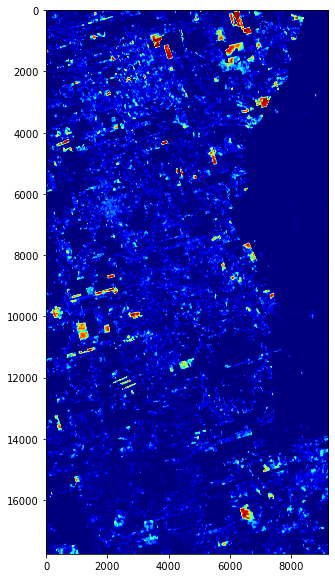

In [13]:
prob_rec = np.zeros((h, w, times))

for tm in range (0, times):
    print(tm)
    prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)

fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')

In [14]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1

# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)

0.5
Metrics th = 0.5:  [[54.3155662  54.91950313]]
